# Comparison of different model architectures

In [1]:
import torchaudio

from util import get_root_path
import util
import torch
from data import AudioDataloader, MSPPodcast
from config import load_hydra_config
from IPython.display import Audio, display
import matplotlib.pyplot as plt

from models import HifiGAN, models_from_config

cfg = load_hydra_config("vc_xlsr", overrides=["data.dataset.segment_size=70000"])
dataloader = AudioDataloader(
    dataset=MSPPodcast(cfg.data, split="development", random_segmentation=False),
    cfg=cfg.data.dataloader,
    batch_size=1,
    shuffle=True,
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vocoder = HifiGAN(cfg.model.vocoder).to(device)
util.load_model(vocoder, "hifigan.pth", freeze=True)
vocoder.eval().dec.remove_weight_norm()

models = {
    "evc_xlsr_f0": {
        "ckpt": get_root_path() / "ckpt" / "ckpt_e42_b1176.pth",
        "cfg": "evc_xlsr",
    },
    "evc_xlsr_yin_l2_norm": {
        "ckpt": get_root_path() / "ckpt" / "evc_xlsr_yin_l2_norm.pth",
        "cfg": "evc_xlsr_yin_l2_norm",
    },
    "evc_xlsr_yin_spk_masking": {
        "ckpt": get_root_path() / "ckpt" / "evc_xlsr_yin_spk_masking.pth",
        "cfg": "evc_xlsr_yin",
    },
    "evc_xlsr_yin_flat_pitch": {
        "ckpt": get_root_path() / "ckpt" / "evc_xlsr_yin_flat_pitch.pth",
        "cfg": "evc_xlsr_yin",
    },
    "evc_xlsr_yin": {
        "ckpt": get_root_path() / "ckpt" / "evc_xlsr_yin.pth",
        "cfg": "evc_xlsr_yin",
    },
    "evc_xlsr_yin_label": {
        "ckpt": get_root_path() / "ckpt" / "ckpt_e14_b392.pth",
        "cfg": "evc_xlsr_yin_label",
    },
    "evc_xlsr_yin_no_norm": {
        "ckpt": get_root_path() / "ckpt" / "ckpt_e31_b868.pth",
        "cfg": "evc_xlsr_yin",
    },
    "evc_autostylizer": {
        "ckpt": get_root_path() / "ckpt" / "evc_autostylizer.pth",
        "cfg": "evc_autostylizer",
    },
    "tkn_evc_xlsr_yin": {
        "ckpt": get_root_path() / "ckpt" / "tkn_xlsr_yin.pth",
        "cfg": "tkn_evc_xlsr_yin",
    },
    "tkn_autostylizer": {
        "ckpt": get_root_path() / "ckpt" / "tkn_autostylizer.pth",
        "cfg": "tkn_autostylizer",
    },
}


def plot_model_output(
        x,
        model_name,
        t = None,
        pitch_shift: bool = False,
        emo_level: int = None,
        emo_type: str = "EmoAct",
        emo_factor: float = 0.0,
        spk_factor: float = 0.0,
):
    if model_name not in models:
        raise ValueError(f"Checkpoint for {model_name} not found.")

    # Load config and models
    cfg_name = models[model_name]["cfg"]
    cfg = load_hydra_config(cfg_name)
    model, preprocessor, style_encoder = models_from_config(cfg, device)

    # Load checkpoint
    ckpt_path = models[model_name]["ckpt"]
    ckpt = torch.load(ckpt_path, map_location=device, weights_only=False)

    model.load_state_dict(ckpt["model"])
    model.requires_grad_(False)
    if hasattr(model, "encoder"):
        model.encoder.dec_ftr.enc.remove_weight_norm()
        model.encoder.dec_src.enc.remove_weight_norm()
    model.eval()
    model.to(device)

    preprocessor.load_state_dict(ckpt["preprocessor"])
    preprocessor.requires_grad_(False)
    preprocessor.eval()
    preprocessor.to(device)

    style_encoder.load_state_dict(ckpt["style_encoder"])
    style_encoder.requires_grad_(False)
    style_encoder.eval()
    style_encoder.to(device)

    # Forward pass
    x = preprocessor(x)

    if t is not None:
        t = preprocessor(t)
        if emo_level is not None:
            g = style_encoder.emotion_conversion(
                t, emo_level, emo_type, emo_factor, spk_factor
            ).unsqueeze(-1)
        else:
            g = style_encoder(t).unsqueeze(-1)
        if pitch_shift:
            x.emb_pitch = preprocessor.pitch_encoder.yin_with_pitch_shift(x.audio, t.audio)
    else:
        if emo_level is not None:
            g = style_encoder.emotion_conversion(
                x, emo_level, emo_type, emo_factor, spk_factor
            ).unsqueeze(-1)
        else:
            g = style_encoder(x).unsqueeze(-1)

    if hasattr(model, "encoder"):
        y_mel, src_mel, ftr_mel = model(x, g, return_enc_out=True, n_time_steps=10)
    else:
        y_mel = src_mel = ftr_mel = model(x, g)

    # Vocode
    enc = vocoder(src_mel + ftr_mel).squeeze(1)
    y = vocoder(y_mel).squeeze(1)

    # Plot
    fig, axs = plt.subplots(2, 3, figsize=(20, 5))
    axs[0,0].imshow(x.mel[0].cpu().numpy(), origin="lower")
    axs[0,0].set_title("Input mel spectrogram")
    axs[0,1].axis("off")
    axs[0,2].imshow(y_mel[0, :, :-3].cpu().numpy(), origin="lower")
    axs[0,2].set_title("Output mel spectrogram")
    axs[1,0].imshow(src_mel[0].cpu().numpy(), origin="lower")
    axs[1,0].set_title("Source mel spectrogram (encoder output)")
    axs[1,1].imshow((src_mel[0] + ftr_mel[0]).cpu().numpy(), origin="lower")
    axs[1,1].set_title("Encoder output")
    axs[1,2].imshow(ftr_mel[0].cpu().numpy(), origin="lower")
    axs[1,2].set_title("Filter mel spectrogram (encoder output)")
    plt.tight_layout()
    plt.show()

    # Audio
    display(Audio(enc.detach().cpu(), rate=cfg.data.dataset.sampling_rate))
    display(Audio(y.detach().cpu(), rate=cfg.data.dataset.sampling_rate))

Removing weight norm...


In [2]:
# x, n_frames, labels = next(iter(dataloader))
x, _ = torchaudio.load(get_root_path() / "sample/src.wav")
x, n_frames, labels = x.to(device), None, None
Audio(x.detach().cpu(), rate=cfg.data.dataset.sampling_rate)

In [3]:
EMO_FACTOR = 1.0
SPK_FACTOR = 1.0

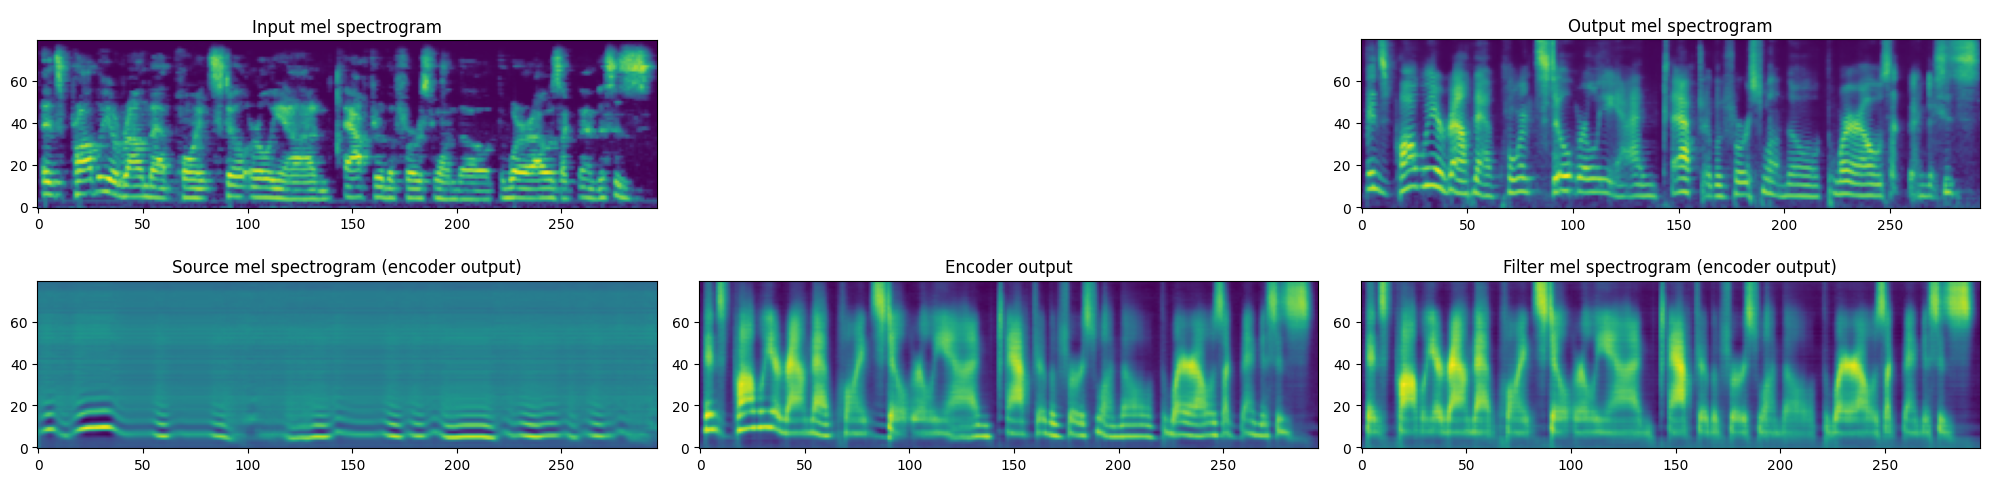

In [4]:
plot_model_output(x, "evc_xlsr_f0", emo_level=1, emo_type="EmoVal", emo_factor=EMO_FACTOR, spk_factor=SPK_FACTOR)

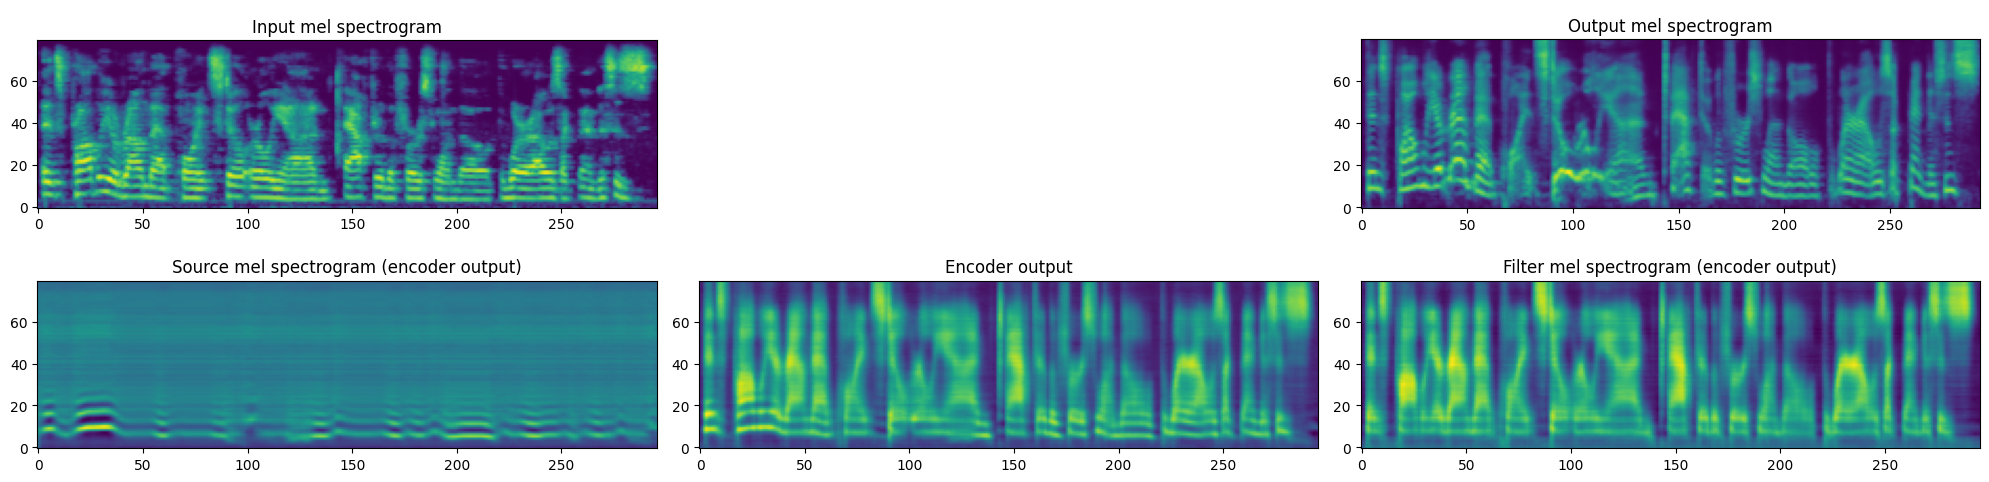

In [5]:
plot_model_output(x, "evc_xlsr_f0", emo_level=7, emo_type="EmoVal", emo_factor=EMO_FACTOR, spk_factor=SPK_FACTOR)

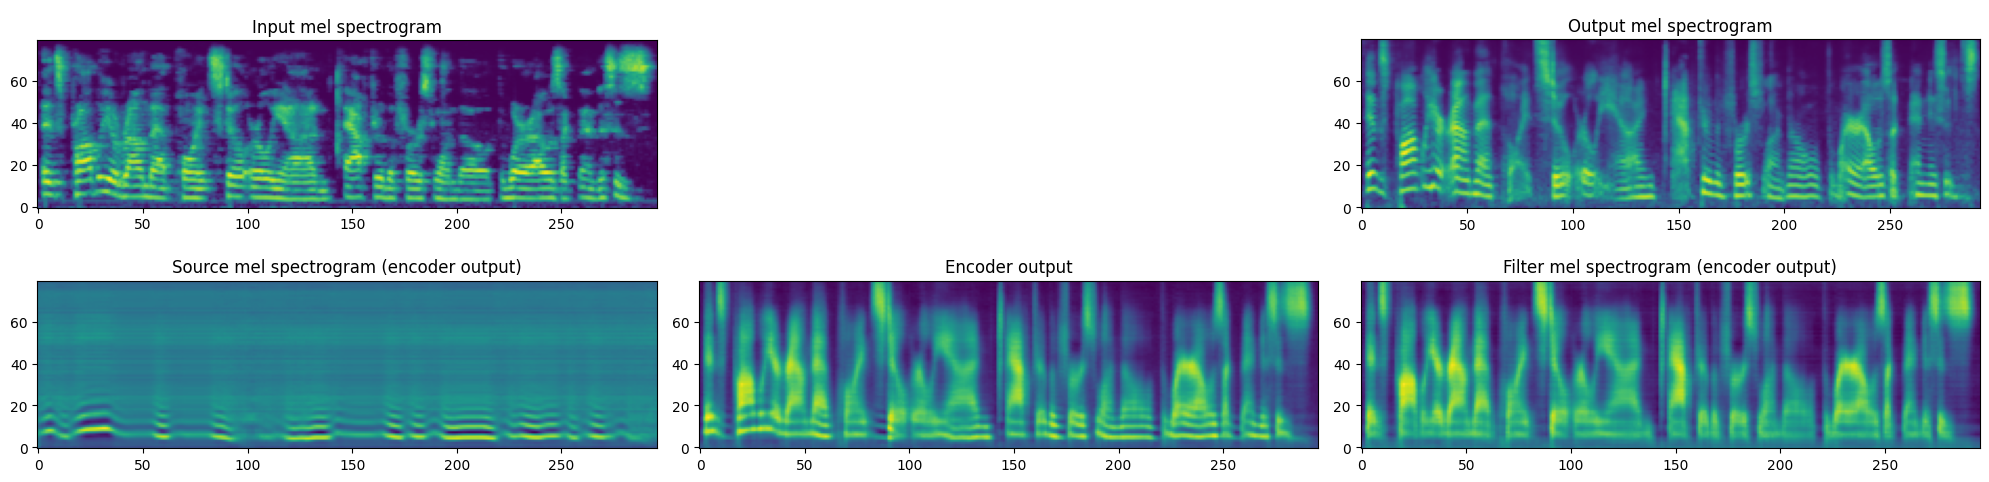

In [6]:
plot_model_output(x, "evc_xlsr_f0", emo_level=1, emo_type="EmoDom", emo_factor=EMO_FACTOR, spk_factor=SPK_FACTOR)

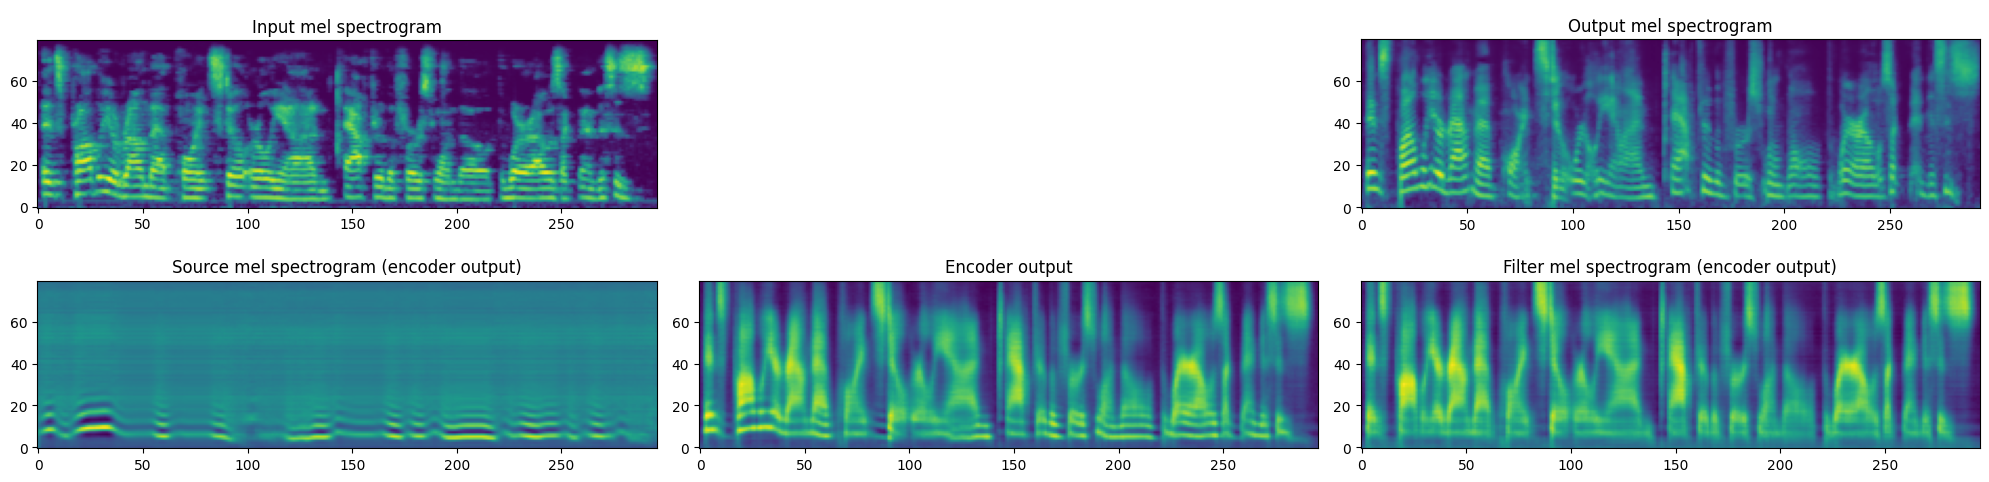

In [7]:
plot_model_output(x, "evc_xlsr_f0", emo_level=7, emo_type="EmoDom", emo_factor=EMO_FACTOR, spk_factor=SPK_FACTOR)

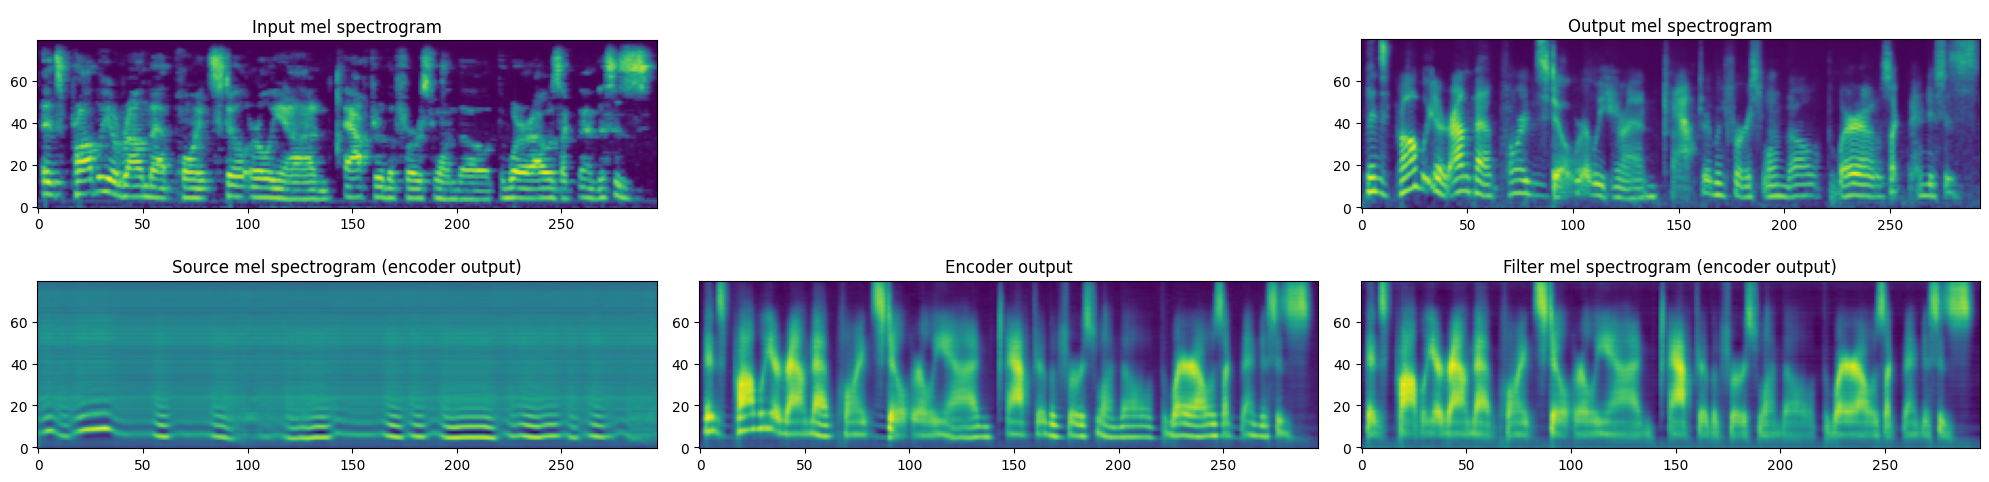

In [15]:
plot_model_output(x, "evc_xlsr_f0", emo_level=1, emo_type="EmoAct", emo_factor=EMO_FACTOR, spk_factor=SPK_FACTOR)

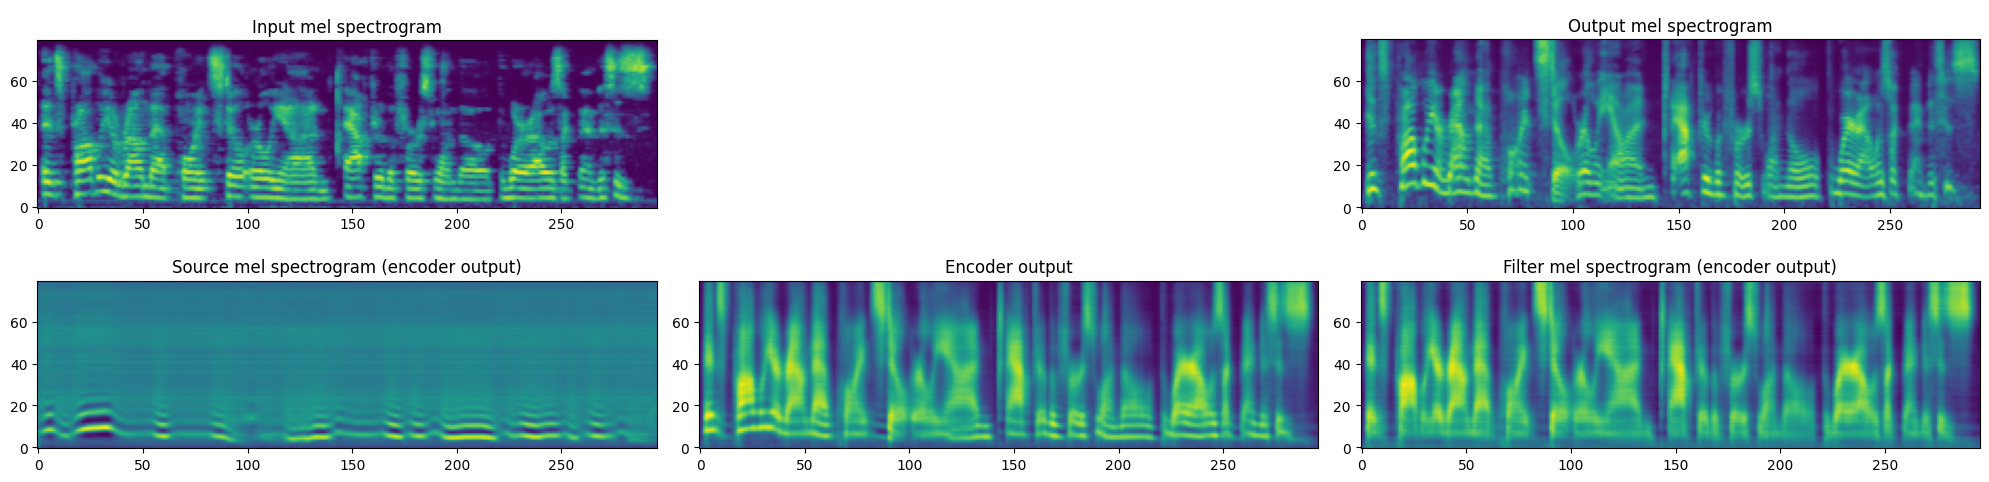

In [14]:
plot_model_output(x, "evc_xlsr_f0", emo_level=7, emo_type="EmoAct", emo_factor=EMO_FACTOR, spk_factor=SPK_FACTOR)